## Lab 1. HP

Настройка гиперпараметров и выбор алгоритма

In [1]:
import pandas as pd
import numpy as np
from scipy.io.arff import loadarff

In [2]:
raw = loadarff('data/raw.arff')
data = pd.DataFrame(raw[0])

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 937 entries, 0 to 936
Data columns (total 50 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   class   937 non-null    object 
 1   attr1   937 non-null    float64
 2   attr2   937 non-null    float64
 3   attr3   937 non-null    float64
 4   attr4   937 non-null    float64
 5   attr5   937 non-null    float64
 6   attr6   937 non-null    float64
 7   attr7   937 non-null    float64
 8   attr8   937 non-null    float64
 9   attr9   937 non-null    float64
 10  attr10  937 non-null    float64
 11  attr11  937 non-null    float64
 12  attr12  937 non-null    float64
 13  attr13  937 non-null    float64
 14  attr14  937 non-null    float64
 15  attr15  937 non-null    float64
 16  attr16  937 non-null    float64
 17  attr17  937 non-null    float64
 18  attr18  937 non-null    float64
 19  attr19  937 non-null    float64
 20  attr20  937 non-null    float64
 21  attr21  937 non-null    float64
 22  at

Предобработайте набор данных, разбейте набор данных на тренировочную, валидационную и тестовую части

In [4]:
data["class"] = data["class"].map(int)

In [5]:
#data.std()
#data.attr23.value_counts()
data.drop(columns=['attr23'], inplace=True)

In [6]:
normalized = (data - data.mean()) / data.std()
normalized["class"] = data["class"]

In [7]:
shuffled = normalized.sample(frac=1, random_state=1337)
train, validate, test = np.split(
    shuffled, [int(0.6 * len(shuffled)), int(0.8 * len(shuffled))])
len(train), len(validate), len(test)

(562, 187, 188)

In [8]:
trainX, trainY = train.drop(columns=["class"]), train["class"]
validateX, validateY = validate.drop(columns=["class"]), validate["class"]
testX, testY = test.drop(columns=["class"]), test["class"]

Сведите задачу выбора алгоритма и настройки гиперпараметров к одной задаче настройки гиперпараметров. Можно использовать любую функцию ошибки.

In [9]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score
import optuna


def objective(trial: optuna.Study):
    classifier_name = trial.suggest_categorical(
        'classifier', ['KNN', 'SVC', 'Gauss', 'Tree', 'SGD']
    )

    if classifier_name == 'KNN':
        neighbors = trial.suggest_int('n_neighbors', 2, 50)
        weights = trial.suggest_categorical('weights', ['uniform', 'distance'])
        p = trial.suggest_float('p', 1.0, 5.0)
        classifier_obj = KNeighborsClassifier(
            n_neighbors=neighbors, weights=weights, p=p
        )
    elif classifier_name == 'SVC':
        C = trial.suggest_float("C", 1e-10, 1e10, log=True)
        kernel = trial.suggest_categorical(
            "kernel", ['linear', 'poly', 'rbf', 'sigmoid'])
        degree = 3
        if kernel == 'poly':
            degree = trial.suggest_int('degree', 1, 5)
        gamma = 'scale'
        if kernel in ['rbf', 'poly', 'sigmoid']:
            gamma = trial.suggest_categorical("gamma", ['scale', 'auto'])
        coef0 = 0.0
        if kernel in ['poly', 'sigmoid']:
            coef0 = trial.suggest_float('coef0', -50.0, 50.0)
        shrinking = trial.suggest_categorical("shrinking", [True, False])
        probability = trial.suggest_categorical("probability", [True, False])
        random_state = trial.suggest_categorical("random_state", [1337])
        classifier_obj = SVC(
            C=C, kernel=kernel, gamma=gamma, shrinking=shrinking,
            probability=probability, random_state=random_state,
            degree=degree, coef0=coef0, max_iter=5000
        )
    elif classifier_name == 'Gauss':
        var_smoothing = trial.suggest_float("smoothing", 1e-9, 1, log=True)
        classifier_obj = GaussianNB(
            var_smoothing=var_smoothing
        )
    elif classifier_name == 'Tree':
        criterion = trial.suggest_categorical(
            "criterion", ["gini", "entropy", "log_loss"])
        splitter = trial.suggest_categorical("splitter", ["best", "random"])
        max_depth = trial.suggest_int("max_depth", 5, 200)
        min_samples_split = trial.suggest_float(
            "min_samples_split", 1e-3, 1 - 1e-3)
        max_features = trial.suggest_categorical(
            "max_features", ["auto", "sqrt", "log2"])
        random_state = trial.suggest_categorical("random_state", [1337])
        classifier_obj = DecisionTreeClassifier(
            criterion=criterion, splitter=splitter, max_depth=max_depth,
            min_samples_split=min_samples_split, max_features=max_features,
            random_state=random_state
        )
    else:
        loss = trial.suggest_categorical("loss", ['hinge', 'log_loss', 'log', 'modified_huber', 'squared_hinge', 'perceptron',
                                                  'squared_error', 'huber', 'epsilon_insensitive', 'squared_epsilon_insensitive'])
        penalty = trial.suggest_categorical(
            "penalty", ['l2', 'l1', 'elasticnet'])
        l1_ratio = trial.suggest_float("l1_ratio", 1e-10, 1, log=True)
        max_iter = trial.suggest_int("max_iter", 10, 5000)
        learning_rate = trial.suggest_categorical(
            "learning_rate", ['constant', 'optimal', 'invscaling', 'adaptive'])
        eta0 = trial.suggest_float("eta0", 1e-10, 3, log=True)
        power_t = trial.suggest_float("power_t", -1, 1)
        random_state = trial.suggest_categorical("random_state", [1337])
        classifier_obj = SGDClassifier(
            loss=loss, penalty=penalty, l1_ratio=l1_ratio,
            max_iter=max_iter, learning_rate=learning_rate,
            eta0=eta0, power_t=power_t, random_state=random_state
        )
    
    classifier_obj.fit(trainX, trainY)
    pred = classifier_obj.predict(validateX)
    return accuracy_score(validateY, pred)


study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=500)

[I 2023-02-16 22:06:45,380] A new study created in memory with name: no-name-dfcdab53-afe5-44d5-8a0a-b252c103e921
[I 2023-02-16 22:06:45,388] Trial 0 finished with value: 0.37433155080213903 and parameters: {'classifier': 'Gauss', 'smoothing': 1.4696700436240618e-09}. Best is trial 0 with value: 0.37433155080213903.
[I 2023-02-16 22:06:45,438] Trial 1 finished with value: 0.5775401069518716 and parameters: {'classifier': 'Gauss', 'smoothing': 8.59970907093886e-06}. Best is trial 1 with value: 0.5775401069518716.
[I 2023-02-16 22:06:45,448] Trial 2 finished with value: 0.9679144385026738 and parameters: {'classifier': 'SVC', 'C': 3.218015702504886e-09, 'kernel': 'linear', 'shrinking': False, 'probability': False, 'random_state': 1337}. Best is trial 2 with value: 0.9679144385026738.
[I 2023-02-16 22:06:45,455] Trial 3 finished with value: 0.9679144385026738 and parameters: {'classifier': 'Tree', 'criterion': 'gini', 'splitter': 'random', 'max_depth': 44, 'min_samples_split': 0.777457832

In [10]:
study.best_value

0.9786096256684492

Сравните полученный результат со случайным поиском.

In [11]:
study_rand = optuna.create_study(direction='maximize', sampler=optuna.samplers.RandomSampler(1337))
study_rand.optimize(objective, n_trials=500)

[I 2023-02-16 22:07:29,254] A new study created in memory with name: no-name-e189834b-788f-48b4-ab58-40674744509d
[I 2023-02-16 22:07:29,263] Trial 0 finished with value: 0.9518716577540107 and parameters: {'classifier': 'Tree', 'criterion': 'log_loss', 'splitter': 'best', 'max_depth': 80, 'min_samples_split': 0.6282441771806322, 'max_features': 'sqrt', 'random_state': 1337}. Best is trial 0 with value: 0.9518716577540107.
[I 2023-02-16 22:07:29,288] Trial 1 finished with value: 0.9518716577540107 and parameters: {'classifier': 'SVC', 'C': 159748.01710328073, 'kernel': 'rbf', 'gamma': 'auto', 'shrinking': False, 'probability': True, 'random_state': 1337}. Best is trial 0 with value: 0.9518716577540107.
[I 2023-02-16 22:07:29,349] Trial 2 finished with value: 0.9679144385026738 and parameters: {'classifier': 'KNN', 'n_neighbors': 37, 'weights': 'uniform', 'p': 1.5065391187633503}. Best is trial 2 with value: 0.9679144385026738.
[I 2023-02-16 22:07:29,360] Trial 3 finished with value: 0.

In [12]:
study_rand.best_value

0.9732620320855615

Оцените на тестовой части конфигурации гиперпараметров, которые были найдены разными методами

In [13]:
study.best_params

{'classifier': 'SVC',
 'C': 48.81218632183156,
 'kernel': 'linear',
 'shrinking': True,
 'probability': False,
 'random_state': 1337}

In [14]:
study_rand.best_params

{'classifier': 'KNN',
 'n_neighbors': 13,
 'weights': 'distance',
 'p': 2.813727175872147}

In [15]:
def test_best(params):
    p = params.copy()
    del p["classifier"]
    classifiers = {
        'KNN': KNeighborsClassifier,
        'SVC': SVC,
        'Gauss': GaussianNB,
        'Tree': DecisionTreeClassifier,
        'SGD': SGDClassifier
    }
    classifier = classifiers[params["classifier"]](**p)
    classifier.fit(trainX, trainY)
    pred = classifier.predict(testX)
    return accuracy_score(testY, pred)

In [16]:
print(test_best(study.best_params), test_best(study_rand.best_params))

0.9308510638297872 0.9361702127659575


Постройте графики зависимости функции ошибки от номера итерации

In [17]:
import matplotlib.pyplot as plt

def draw(ax, trials):
    x = range(1, len(trials) + 1)
    y = [i.values[0] for i in trials]
    ax.scatter(x, y)

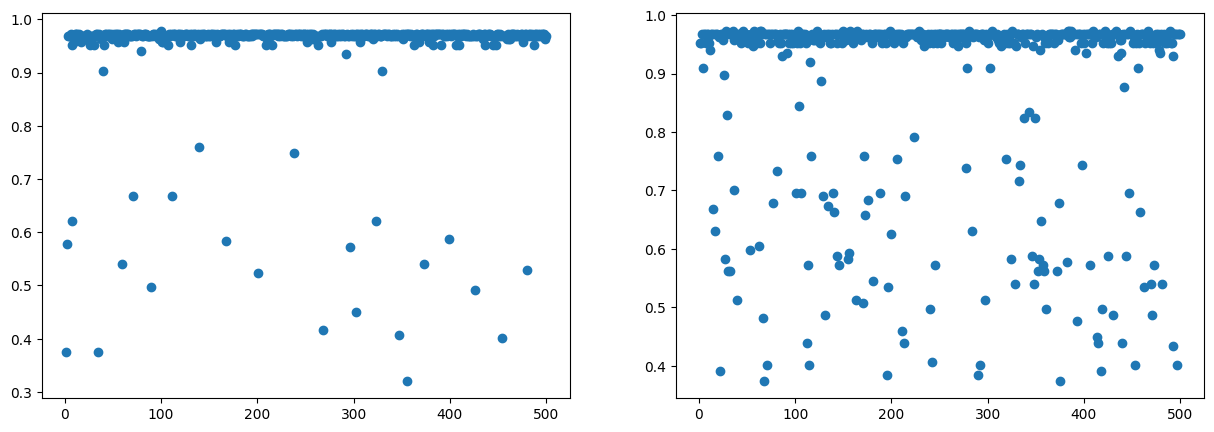

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
draw(axes[0], study.get_trials())
draw(axes[1], study_rand.get_trials())

In [19]:
optuna.visualization.plot_optimization_history(study)

In [20]:
optuna.visualization.plot_optimization_history(study_rand)

Выведите также информацию о полезности гиперпараметров

In [21]:
fig = optuna.visualization.plot_param_importances(study, params=["C", "kernel", "shrinking", "probability"])
fig.show()

In [22]:
fig = optuna.visualization.plot_param_importances(study_rand, params=["n_neighbors", "weights", "p"])
fig.show()